In [121]:
import pandas as pd
import numpy as np
import requests as r
from bs4 import BeautifulSoup as bs
from selenium import webdriver as wd
from sqlalchemy import create_engine
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import math
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_validate
import plotly.graph_objects as go
%matplotlib inline
#%matplotlib notebook

In [88]:
original_state_data = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")
other_data = pd.read_csv("https://covidtracking.com/api/v1/states/daily.csv")
state_info = pd.read_csv("state_info.csv")

In [89]:
other_data.date = pd.to_datetime([str(i)[0:4] + "-" + str(i)[4:6]+"-"+str(i)[6:] for i in other_data.date])

In [90]:
state_stayhome = pd.DataFrame(columns=("state", "date"))
stayhome = ["April 4, 2020", "March 28, 2020", "March 31, 2020", None, "March 19, 2020", "March 26, 2020", "March 23, 2020", 
            "March 24, 2020", "April 1, 2020", "April 3, 2020", "April 3, 2020", None, "March 25,2020", 
            "March 25, 2020", "March 21, 2020", "March 24, 2020", None, "March 30, 2020", "March 26, 2020", "March 23, 2020", 
            "April 2, 2020", "March 30, 2020", "March 24, 2020", "March 24, 2020", "March 27, 2020", "April 3, 2020", 
            "April 6, 2020", "March 28, 2020", None, "April 1, 2020", "March 27, 2020", "March 21, 2020", "March 24, 2020", 
            "March 22, 2020", "March 30, 2020", None, None, "March 23, 2020", None, "March 23, 2020", "April 1, 2020",
            "March 15, 2020", "March 28, 2020", "April 7, 2020", None, "March 31, 2020" ,"April 2, 2020", None, "March 25, 2020", 
            None, "March 30, 2020", "March 23, 2020", "March 24, 2020", "March 25, 2020", None]
state_stayhome['state'] = np.sort(original_state_data.state.unique())
state_stayhome['date'] = stayhome
state_stayhome

,state,date
0,Alabama,"April 4, 2020"
1,Alaska,"March 28, 2020"
2,Arizona,"March 31, 2020"
3,Arkansas,None
4,California,"March 19, 2020"
5,Colorado,"March 26, 2020"
6,Connecticut,"March 23, 2020"
7,Delaware,"March 24, 2020"
8,District of Columbia,"April 1, 2020"
9,Florida,"April 3, 2020"


In [91]:
new_other_data = other_data.merge(state_info, left_on='state', right_on='Code').drop(['state', 'Abbrev'], axis=1)
original_state_data.date = pd.to_datetime(original_state_data.date)
state_data = original_state_data.merge(new_other_data, left_on=['state', 'date'], right_on=['State', 'date'])

In [93]:
def casesPerDay(df):
    df['new_cases'] = 0
    for state in df.state.unique():
        i = 0
        oldRowVal = 0
        for index, row in df[df.state==state].iterrows():
            if i == 0:
                i += 1
            else:
                row['new_cases'] = row['cases'] - oldRowVal
                df.loc[index, :] = row
            oldRowVal = row['cases']
    return df
new_state_data = casesPerDay(state_data)

In [94]:
def since100states(group):
    start = group.loc[group.cases >= 1000,'date'].min()
    group['day0'] = start
    return group
since_100_states = new_state_data.copy()
since_100_states['date'] = pd.to_datetime(since_100_states['date'])
since_100_states = since_100_states.groupby("state").apply(since100states)
#since_100_states = since_100_states.dropna()
since_100_states['day25'] = since_100_states['date'] - since_100_states['day0']
since_100_states['day25'] = [i.days for i in since_100_states['day25']]
since_100_states = since_100_states[since_100_states.day25 >= 0].reset_index()
since_100_states.head()

,index,date,state,fips_x,cases,deaths,positive,negative,pending,hospitalizedCurrently,...,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,State,Code,new_cases,day0,day25
0,564,2020-03-17,New York,36,1375,18,1700.0,5506.0,NaN,325.0,...,0.0,0.0,963.0,750.0,1713.0,New York,NY,425,2020-03-17,0.0
1,615,2020-03-18,New York,36,2387,32,2382.0,12215.0,NaN,416.0,...,5.0,0.0,6709.0,682.0,7391.0,New York,NY,1012,2020-03-17,1.0
2,630,2020-03-18,Washington,53,1026,68,2129.0,31812.0,NaN,NaN,...,4.0,0.0,4468.0,289.0,4757.0,Washington,WA,118,2020-03-18,0.0
3,638,2020-03-19,California,6,1067,19,924.0,8787.0,NaN,NaN,...,5.0,0.0,806.0,313.0,1119.0,California,CA,174,2020-03-19,0.0
4,666,2020-03-19,New York,36,4161,39,4152.0,18132.0,NaN,617.0,...,0.0,0.0,5917.0,1770.0,7687.0,New York,NY,1774,2020-03-17,2.0


In [100]:
since_100_states[['positive', 'negative', 'pending', 'total', 'totalTestResults']]

,positive,negative,pending,total,totalTestResults
0,1700.0,5506.0,NaN,7206,7206
1,2382.0,12215.0,NaN,14597,14597
2,2129.0,31812.0,NaN,33941,33941
3,924.0,8787.0,NaN,9711,9711
4,4152.0,18132.0,NaN,22284,22284
...,...,...,...,...,...
2374,8057.0,178777.0,NaN,186834,186834
2375,34950.0,190225.0,464.0,225639,225175
2376,19117.0,283810.0,NaN,302927,302927
2377,1616.0,83213.0,NaN,84829,84829


In [96]:
for col in since_100_states.columns:
    print(col)

index
date
state
fips_x
cases
deaths
positive
negative
pending
hospitalizedCurrently
hospitalizedCumulative
inIcuCurrently
inIcuCumulative
onVentilatorCurrently
onVentilatorCumulative
recovered
dataQualityGrade
lastUpdateEt
hash
dateChecked
death
hospitalized
total
totalTestResults
posNeg
fips_y
deathIncrease
hospitalizedIncrease
negativeIncrease
positiveIncrease
totalTestResultsIncrease
State
Code
new_cases
day0
day25


Text(0, 0.5, 'Total Number of Cases/Deaths')

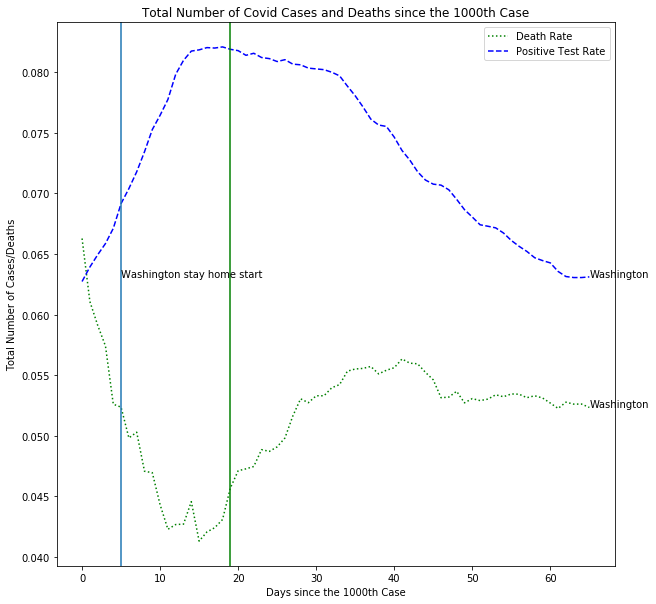

In [120]:
lookatstates = since_100_states.loc[since_100_states.cases > 10000, 'state'].unique()
#lookatstates = ["Florida", "Texas", "Washington", "California", "Alabama"]
lookatstates = ["Washington"]
fig5, ax5 = plt.subplots(figsize=(10, 10))
label = None
wa_stayathome = (pd.to_datetime("2020-03-18") - pd.to_datetime("2020-02-29")).days
wa_twoweek = wa_stayathome + 14
for state in lookatstates:
    x = since_100_states.loc[since_100_states.state==state, 'day25'].values
    y = since_100_states.loc[since_100_states.state==state, 'cases'].values
    y2 = since_100_states.loc[since_100_states.state==state, 'deaths'].values
    y3 = since_100_states.loc[since_100_states.state==state, 'new_cases'].values
    y4 = y2 / y
    y5 = since_100_states.loc[since_100_states.state==state, 'positive'].values /  since_100_states.loc[since_100_states.state==state, 'total'].values
    if not(label):
        #ax5.plot(x, y, label='Cases', color='blue')
        #ax5.plot(x, y2, linestyle="--", label="Deaths", color='red')
        ax5.plot(x, y4, linestyle="dotted", label="Death Rate", color='green')
        ax5.plot(x, y5, linestyle="--", label="Positive Test Rate", color='blue')
        label=True
    else:
        #ax5.plot(x, y, color="blue")
        #ax5.plot(x, y2, linestyle="--", color='red')  
        ax5.plot(x, y4, linestyle="dotted", color='green')
        ax5.plot(x, y5, linestyle="--", color='blue')
        label=True
    #ax5.plot(x, y3, label=state)
    
    #ax5.annotate(state, xy=(x[-1], y[-1]))
    #ax5.annotate(state, xy=(x[-1], y2[-1]))
    #ax5.annotate(state, xy=(x[-1], y3[-1]))
    ax5.annotate(state, xy=(x[-1], y4[-1]))
    ax5.annotate(state, xy=(x[-1], y5[-1]))
    if state_stayhome.loc[state_stayhome.state==state, "date"].values != None:
        states_stayhome = (pd.to_datetime(state_stayhome.loc[state_stayhome.state==state, "date"].values) - pd.to_datetime(since_100_states.loc[since_100_states.state==state, 'day0']).values[0]).days
    
    ax5.annotate(state + " stay home start", xy=(states_stayhome[0], y5[-1]))
    ax5.axvline(states_stayhome)
    ax5.axvline(states_stayhome + 14, color="green")

#wa_stayhome = (pd.to_datetime(state_stayhome.loc[state_stayhome.state==state, "date"].values) - pd.to_datetime(since_100_states.loc[since_100_states.state==state, 'day0']).values[0]).days
#ax5.axvline(wa_stayhome + 14)
texas_stayhome_lifted = (pd.to_datetime("April 30, 2020") - pd.to_datetime(since_100_states.loc[since_100_states.state=="Texas", 'day0']).values[0]).days
#ax5.axvline(texas_stayhome_lifted, color="red")
#ax5.annotate(state + " stay home end", xy=(texas_stayhome_lifted, y5[-1]))
#two_week_lag_texas = texas_stayhome_lifted+14
#ax5.axvline(two_week_lag_texas, color="green")


ax5.legend()
ax5.set_title("Total Number of Covid Cases and Deaths since the 1000th Case")
ax5.set_xlabel("Days since the 1000th Case")
ax5.set_ylabel("Total Number of Cases/Deaths")
#plt.savefig('texas-cases-deaths-since-1000.png')

In [164]:
since_100_states['death_rate'] = since_100_states['deaths'] / since_100_states['cases']
since_100_states['positive_test_rate'] = since_100_states['positive'] / since_100_states['total']

gofig = go.Figure()
x = x = since_100_states.loc[since_100_states.state=="Alabama", 'day25'].values
y = since_100_states.loc[since_100_states.state=="Alabama", 'positive_test_rate'].values
y2 = since_100_states.loc[since_100_states.state=="Alabama", 'death_rate'].values
gofig.add_trace(go.Scatter(x=x, y=y, visible=True, name="Positive Test Rate"))
gofig.add_trace(go.Scatter(x=x, y=y2, visible=True, name="Death Rate"))

updateMenu = []
updateButton = []
for state in np.sort(since_100_states.state.unique()):
    updateButton.append(dict(method='restyle',
                        label=state,
                        visible=True,
                        args=[{'y':[since_100_states.loc[since_100_states.state==state, 'positive_test_rate'].values, since_100_states.loc[since_100_states.state==state, 'death_rate'].values],
                               'type':'scatter'}, [0, 1]],
                        )
                  )
myMenu = dict()
updateMenu.append(myMenu)
updateMenu[0]['buttons'] = updateButton
updateMenu[0]['direction'] = 'down'
updateMenu[0]['showactive'] = True
gofig.update_layout(showlegend=True, updatemenus=updateMenu)
gofig.show()
gofig.write_html('state_positive_test_rate.html')

In [7]:
states_rgr = since_100_states.groupby("state")[['cases', 'deaths', 'day0']].max().reset_index()
states_rgr['Days Between Stay At Home order and 1000th Case'] = None
for state in states_rgr.state.unique():
    states_rgr.loc[states_rgr.state == state, "Days Between Stay At Home order and 1000th Case"] = (pd.to_datetime(state_stayhome.loc[state_stayhome.state == state, "date"].values) - pd.to_datetime(since_100_states.loc[since_100_states.state==state, 'day0']).values[0]).days[0]

states_rgr = states_rgr.dropna()
states_rgr['Days Between Stay At Home order and 1000th Case'] = states_rgr['Days Between Stay At Home order and 1000th Case'].astype('int')
m = smf.ols('cases ~ Q("Days Between Stay At Home order and 1000th Case")', data=states_rgr).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  cases   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.401
Date:                Thu, 21 May 2020   Prob (F-statistic):             0.0426
Time:                        14:59:39   Log-Likelihood:                -494.85
No. Observations:                  40   AIC:                             993.7
Df Residuals:                      38   BIC:                             997.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                             4.417e+04   9778.666      4.517      0.000    2.44e+04     6.4e+04
Q("Days Between Stay At Home order and 1000th Case")  1908.4921    909.693      2.098      0.043      66.916    3750.068
==============================================================================
Omnibus:                       66.120   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              638.835
Skew:                           3.962   Prob(JB):                    1.90e-139
Kurtosis:                      20.903   Cond. No.                         11.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

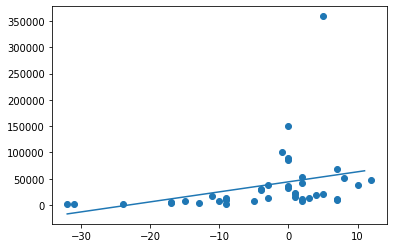

In [8]:
xvals = np.arange(states_rgr["Days Between Stay At Home order and 1000th Case"].min(), states_rgr["Days Between Stay At Home order and 1000th Case"].max())
yhat = m.params[0] + m.params[1] * xvals
plt.scatter(states_rgr["Days Between Stay At Home order and 1000th Case"], states_rgr.cases)
#for state in states_rgr.state:
#    plt.annotate(state, xy=(states_rgr.loc[states_rgr.state==state, "Days Between Stay At Home order and 1000th Case"], states_rgr.loc[states_rgr.state==state, "deaths"]))
plt.plot(xvals, yhat)